In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import DataLoader

In [55]:
# Helper function to calculate higher order gradients
def calcGradients(function, x, order):
    y = function(x)
    f_primes = torch.ones_like(x)
    for order_i in range(order):
        # Possibly you could create graph only for order_i+1 < order
        f_primes = torch.autograd.grad(outputs=y, inputs=x, grad_outputs=f_primes, create_graph=True, retain_graph=True)[0]
        y = f_primes
    return f_primes


class DNN(nn.Module):
    def __init__(self, input_shape, hidden_shapes, output_shape):
        super(DNN, self).__init__()
        # TODO modify this to be more flexible
        self.model = nn.Sequential(
            nn.Linear(input_shape, hidden_shapes[0]),
            nn.Sigmoid(),
            nn.Linear(hidden_shapes[0],hidden_shapes[1]),
            nn.Sigmoid(),
            nn.Linear(hidden_shapes[1],hidden_shapes[2]),
            nn.Sigmoid(),
            nn.Linear(hidden_shapes[2],output_shape)
        )
    
    def forward(self, x):
        return self.model(x)


# QUESTION Should I make this inherit from nn.Module?
# COMMENT you should probably only calculate the BC for when the loss function is called with BC value
class LossFunction:
    def __init__(self, differential_expressions, bc_grad_orders, bc_functions, boundaries):
        # Differential expression term sum_i F(x_i,f(x_i),f'(x_i),...)^2
        self.differential_expressions = differential_expressions  # function F(x_i,f(x_i),f'(x_i),...)
        # Boundary condition term sum_i (grad^{p_i} f(x_{b_i})- K_i(x_{b_i}))^2
        self.bc_grad_orders = bc_grad_orders    # list of integer p
        self.bc_functions = bc_functions        # list of function K(x_b)
        self.boundaries = boundaries            # list of tensors(!!!!!!!) of values x_b 
        for i, b in enumerate(boundaries):
            self.boundaries[i] = torch.tensor([b], requires_grad=True).float()
        self.problem_order = len(self.boundaries)  # integer of the differential equation order
        assert self.problem_order == len(bc_functions) and self.problem_order == len(self.bc_grad_orders)

    def _calcBC(self, model):
        # Calculates the boundary condition term
        # sum_i (grad^{p_i} f(x_{b_i})- K_i(x_{b_i}))^2

        # bc_orders is list if integer values
        # bc_functions is list of functions
        # boundaries is list of values

        bc_term = 0.0
        for i in range(self.problem_order):
            bc_term += (calcGradients(model, self.boundaries[i], self.bc_grad_orders[i]) - self.bc_functions[i](self.boundaries[i]))**2
    
        # # Alternative implementation??
        # # Convert lists to tensors
        # bc_grad_orders = torch.tensor(self.bc_grad_orders)
        # boundaries = torch.stack(self.boundaries)
        # 
        # # Calculate gradients
        # gradients = [calcGradients(model, boundary, order) for boundary, order in zip(boundaries, bc_grad_orders)]
        # gradients = torch.stack(gradients)
        # 
        # # Calculate boundary condition functions
        # bc_values = [bc_function(boundary) for bc_function, boundary in zip(self.bc_functions, boundaries)]
        # bc_values = torch.stack(bc_values)
        # 
        # # Calculate boundary condition term
        # bc_term = (gradients - bc_values).square().sum()

        return bc_term
        
    def __call__(self, model, x_data):
        # (sum_i F(x_i,f(x_i),f'(x_i),...))^2 + BC_term
        # QUESTION do you calculate boundary condition everytime even with smaller batches?
        # QUESTION shuold you remove the boundary values from x_data?
        # NB works only for single differential expression, i.e. not for many coupled expressions
        # TODO have `differential_expressions` be list of the given differential expressions and calculate sum
        # similarly as in the boundary condition case.
        # NB x_data shold have `requires_grad=True`
        x_max = x_data.shape[0]
        F_term = self.differential_expressions(model, x_data).square().sum() / x_max
        BC_term = self._calcBC(model)
        print("F_term", F_term)
        print("BC_term", BC_term)
        return F_term + BC_term



def training(model, loss_fn, dataloader, num_epochs, learning_rate):
    # Possible parameters for Adam: ...
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    loss_history = []

    # Initial loss value
    model.eval()
    init_loss = 0.0
    for i, x in enumerate(dataloader):
        x = x.unsqueeze(-1)
        init_loss += loss_fn(model, x).item()
    print("Initial loss: {:.4f}".format(init_loss))

    model.train()
    for epoch_i in range(num_epochs):
        # model.train()  # NB train is default. Can also set model.eval()
        running_loss = 0.0
        for batch_i, x in enumerate(dataloader):
            x = x.unsqueeze(-1)
            optimizer.zero_grad()

            # Forward pass (loss function only requires model and x)
            # y = model(x)

            # Backward pass
            loss = loss_fn(model, x)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        loss_history.append(running_loss)
        print("Epoch {}/{} Loss: {:.4f}". format(epoch_i+1, num_epochs, running_loss))

    return loss_history




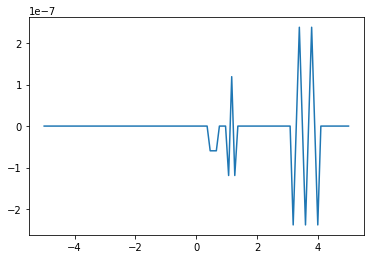

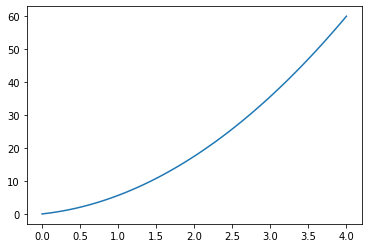

In [56]:
# Example f'(x) - x - 1 = 0, with e.g. f(0) = 0, on domain x in [0,infty)
# Solution f(x) = x^2/2 + x + c, where f(0) = c = 0
def equation1(f, x):
    assert isinstance(x, torch.Tensor), "x must be a Pytorch tensor"
    assert x.requires_grad, "x must have `requires_grad=True`"
    y = f(x)
    f_prime = grad(outputs=y, inputs=x, grad_outputs=torch.ones_like(x), create_graph=True, retain_graph=True)[0]
    return f_prime - x - 1


def bc_equation1(x):
    return 0.0

p_test = 0

x_b = 0.0

loss_fn_test = LossFunction(equation1, [p_test], [bc_equation1], [x_b])


def f_analytic(x):
    return x**2 * 0.5 + x


def f_dummy(x):
    return x**2


x_test = torch.linspace(-5, 5, 100, requires_grad=True)
y_test = equation1(f_analytic, x_test)

plt.plot(x_test.detach(), y_test.detach())
plt.show()

plt.plot(np.linspace(0,4,100), f_analytic(np.linspace(0,10,100)))
plt.show()



F_term tensor(2.3213, grad_fn=<DivBackward0>)
BC_term tensor([1.])
Initial loss: 3.3213
F_term tensor(2.3213, grad_fn=<DivBackward0>)
BC_term tensor([1.])
Epoch 1/1000 Loss: 3.3213
F_term tensor(2.2513, grad_fn=<DivBackward0>)
BC_term tensor([1.])
Epoch 2/1000 Loss: 3.2513
F_term tensor(2.1497, grad_fn=<DivBackward0>)
BC_term tensor([1.])
Epoch 3/1000 Loss: 3.1497
F_term tensor(1.9976, grad_fn=<DivBackward0>)
BC_term tensor([1.])
Epoch 4/1000 Loss: 2.9976
F_term tensor(1.7914, grad_fn=<DivBackward0>)
BC_term tensor([1.])
Epoch 5/1000 Loss: 2.7914
F_term tensor(1.5340, grad_fn=<DivBackward0>)
BC_term tensor([1.])
Epoch 6/1000 Loss: 2.5340
F_term tensor(1.2365, grad_fn=<DivBackward0>)
BC_term tensor([1.])
Epoch 7/1000 Loss: 2.2365
F_term tensor(0.9190, grad_fn=<DivBackward0>)
BC_term tensor([1.])
Epoch 8/1000 Loss: 1.9190
F_term tensor(0.6095, grad_fn=<DivBackward0>)
BC_term tensor([1.])
Epoch 9/1000 Loss: 1.6095
F_term tensor(0.3480, grad_fn=<DivBackward0>)
BC_term tensor([1.])
Epoch 10

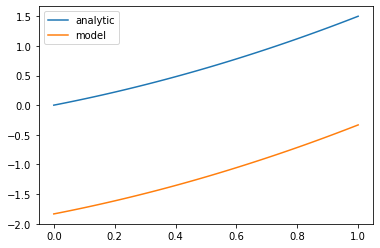

In [57]:
# Domain discretization
discretization_delta = 0.01
x = np.arange(0, 1, discretization_delta)

# Define dataloader
x_tensor = torch.from_numpy(x).float().requires_grad_(True)
dataloader_test = DataLoader(x_tensor, batch_size=100, shuffle=True)

# Define model
hidden_shapes=[200,50,10]
model = DNN(1, hidden_shapes, 1)

# Training parameters
num_epochs = 1000
learning_rate = 0.01
training(model, loss_fn_test, dataloader_test, num_epochs=num_epochs, learning_rate=learning_rate)

# Visual evaluation
model.eval()
x_eval = np.linspace(0,1,100)
y_analytic = f_analytic(x_eval)
x_eval_tensor = torch.from_numpy(x_eval).float().unsqueeze(-1)
y_model = model(x_eval_tensor).detach().flatten().numpy()

plt.plot(x_eval, y_analytic, label="analytic")
plt.plot(x_eval, y_model, label="model")
plt.legend()
plt.show()

The boundary condition loss is not optimized at all...

Maybe because for p=0 it does not currently depend on model at all? Also consider modifying how the boundary condition values are taken into account with possibly different batches.

Also looking at the prints above, is there something wrong about the gradient graphs of BC_term tensor?